In [6]:
#Install some dependencies
!pip install -q tensorflow-hub
!pip install -q tensorflow-text  # A dependency of the preprocessing for BERT inputs
!pip install -q tf-models-official # For the AdamW optimizer from tensorflow/models
!pip install bert-for-tf2
!pip install sentencepiece

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# Trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review.
# https://www.tensorflow.org/tutorials/text/classify_text_with_bert
# https://analyticsindiamag.com/bert-classifier-with-tensorflow-2-0/
#
# EXAMPLE: https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/
# Data: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [8]:
train_ds = pd.read_parquet("/content/drive/MyDrive/DL_proyecto/train_DL_preparado.parquet")
test_ds = pd.read_parquet("/content/drive/MyDrive/DL_proyecto/test_DL_preparado.parquet")

# Section 1: Load data

Dado que vamos a correr distintos modelos, se plantearon distintas bases de datos: 1) una que considera sólo source_code y address, 2) una que considera ólo bytecode y address, 3) una que considera las dos.

In [9]:
import string 

def diverse_splits(df):
    df=pd.DataFrame(df)
    n=df.shape[0]
    x=df.drop('slither',axis=1)
    x['source_code']= np.array([x['source_code'][i].encode() for i in range(n)], dtype=object)
    x['bytecode']= np.array([x['bytecode'][i].encode() for i in range(n)], dtype=object)
    x['address']= np.array([x['address'][i].encode() for i in range(n)], dtype=object)
    y=df['slither']
    x_full=x
    x_byte=x['bytecode']
    x_source=x['source_code']
    return x_full,x_byte,x_source,y

xtrain_full,xtrain_byte,xtrain_source,ytrain=diverse_splits(train_ds)
xtest_full,xtest_byte,xtest_source,ytest=diverse_splits(test_ds)

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
train_ds['source_code'].dtype

dtype('O')

In [12]:
# DEFINE BERT models for preporcessing and embedding
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

# Section 2: RNN

In [13]:
# Create RNN model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') #input layer

preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') #BERT tokenizer
tokenized = preprocessor(text_input)
tokens = tokenized['input_word_ids'] #BERT returns tokens, mask, and sentence index. Keep only the tokens

h = tf.keras.layers.Embedding(input_length=128  , input_dim=30000, output_dim=64, trainable=True)(tokens)
h = tf.keras.layers.Dropout(0.1)(h)
h = tf.keras.layers.SimpleRNN(units=32)(h)
h = tf.keras.layers.Dropout(0.1)(h)
o = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(h)

model_RNN = tf.keras.Model(text_input, o)
model_RNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None,)]                 0         
                                                                 
 preprocessing (KerasLayer)  {'input_word_ids': (None  0         
                             , 128),                             
                              'input_mask': (None, 12            
                             8),                                 
                              'input_type_ids': (None            
                             , 128)}                             
                                                                 
 embedding (Embedding)       (None, 128, 64)           1920000   
                                                                 
 dropout (Dropout)           (None, 128, 64)           0         
                                                             

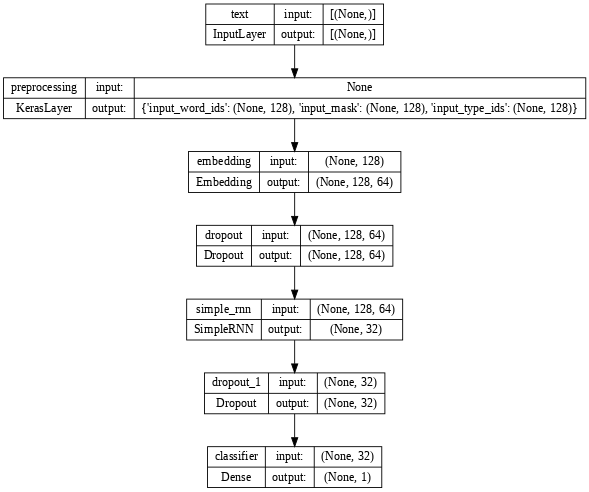

In [14]:
# Plot model
tf.keras.utils.plot_model(model_RNN, show_shapes=True, show_layer_names=True, dpi=64)

In [16]:
# Compile
model_RNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])
history_source = model_RNN.fit(x=xtrain_source, y=ytrain, epochs=10, batch_size=64,validation_data=(xtest_source, ytest))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


845/845 [==============================] - 976s 1s/step - loss: 0.4764 - binary_accuracy: 0.7711 - val_loss: 0.5250 - val_binary_accuracy: 0.7288
Epoch 2/10
845/845 [==============================] - 910s 1s/step - loss: 0.4426 - binary_accuracy: 0.7879 - val_loss: 0.5027 - val_binary_accuracy: 0.7460
Epoch 3/10
845/845 [==============================] - 899s 1s/step - loss: 0.4071 - binary_accuracy: 0.8101 - val_loss: 0.4801 - val_binary_accuracy: 0.7701
Epoch 4/10
845/845 [==============================] - 903s 1s/step - loss: 0.3720 - binary_accuracy: 0.8278 - val_loss: 0.4750 - val_binary_accuracy: 0.7753
Epoch 5/10
845/845 [==============================] - 904s 1s/step - loss: 0.3629 - binary_accuracy: 0.8335 - val_loss: 0.4671 - val_binary_accuracy: 0.7814
Epoch 6/10
845/845 [==============================] - 918s 1s/step - loss: 0.3628 - binary_accuracy: 0.8312 - val_loss: 0.5358 - val_binary_accuracy: 0.7303
Epoch 7/10
845/845 [==============================] - 894s 1s/step - 

In [17]:
history_byte_rnn = model_RNN.fit(x=xtrain_byte, y=ytrain, epochs=10, batch_size=64,validation_data=(xtest_byte, ytest))

Epoch 1/10
845/845 [==============================] - 217s 257ms/step - loss: 0.7138 - binary_accuracy: 0.4968 - val_loss: 0.6934 - val_binary_accuracy: 0.5001
Epoch 2/10
845/845 [==============================] - 217s 257ms/step - loss: 0.7001 - binary_accuracy: 0.5024 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 3/10
845/845 [==============================] - 217s 257ms/step - loss: 0.6970 - binary_accuracy: 0.4970 - val_loss: 0.6938 - val_binary_accuracy: 0.5000
Epoch 4/10
845/845 [==============================] - 217s 257ms/step - loss: 0.6957 - binary_accuracy: 0.4987 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 5/10
845/845 [==============================] - 218s 258ms/step - loss: 0.6945 - binary_accuracy: 0.5021 - val_loss: 0.6962 - val_binary_accuracy: 0.5000
Epoch 6/10
845/845 [==============================] - 218s 258ms/step - loss: 0.6944 - binary_accuracy: 0.4947 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 7/10
845/845 [====================

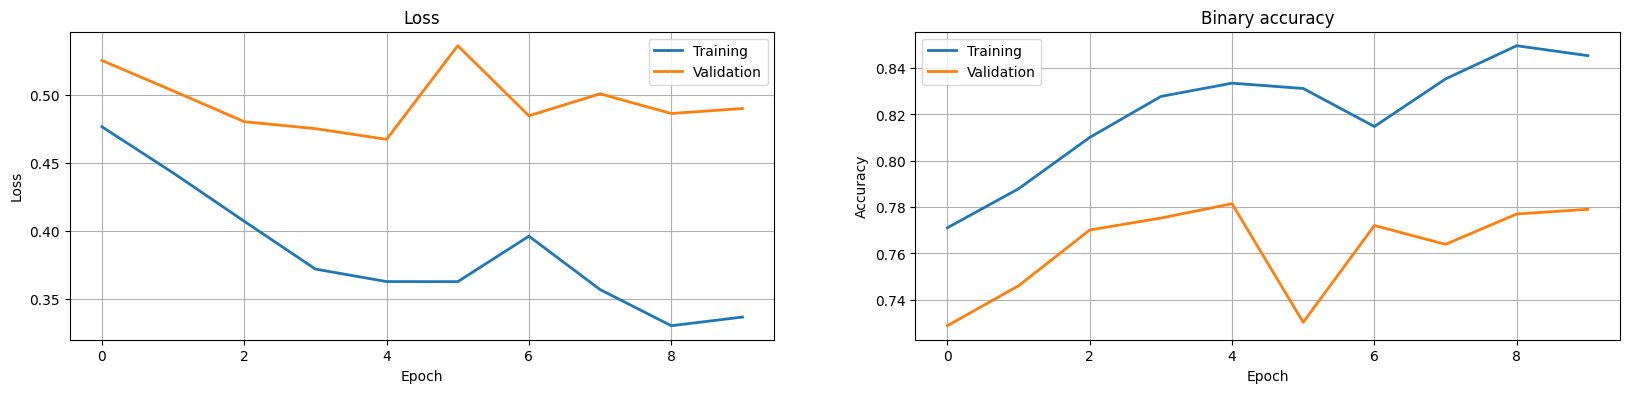

In [18]:
# Plot loss sourcecode dataset
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history_source.history['loss'], label='Training', linewidth=2)
plt.plot(history_source.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history_source.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history_source.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

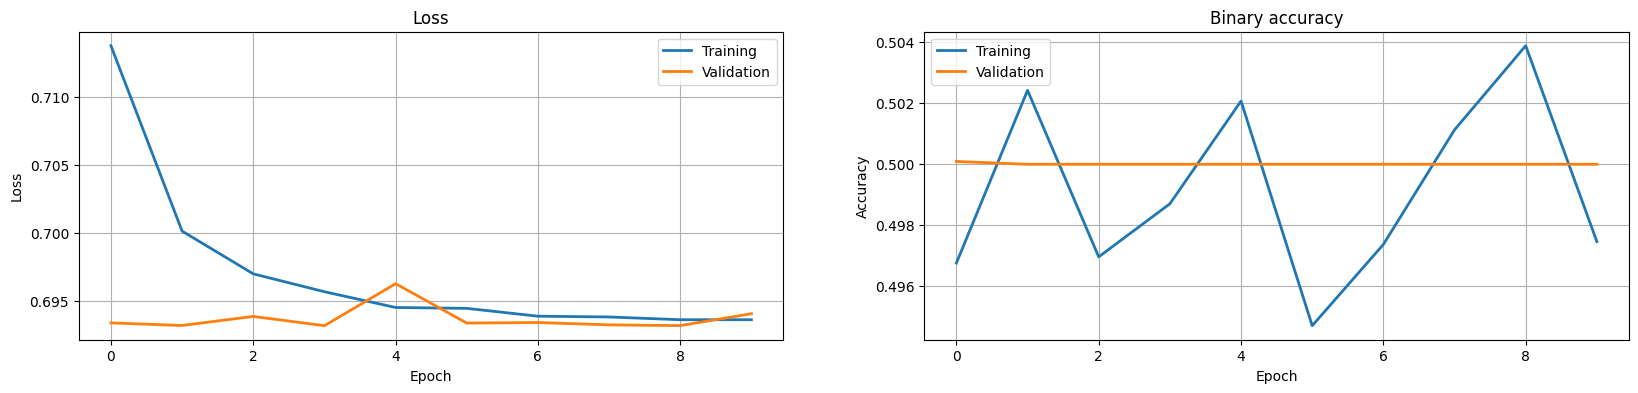

In [19]:
# Plot loss sourcecode dataset
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history_byte.history['loss'], label='Training', linewidth=2)
plt.plot(history_byte.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history_byte.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history_byte.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

# Section 3: LSTM

In [22]:
# Create LSTM model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') #input layer

preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') #BERT tokenizer
tokenized = preprocessor(text_input)
tokens = tokenized['input_word_ids'] #BERT returns tokens, mask, and sentence index. Keep only the tokens

h = tf.keras.layers.Embedding(input_length=128, input_dim=30000, output_dim=64, trainable=True)(tokens)
h = tf.keras.layers.LSTM(units=32)(h)
o = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(h)

model_LSTM = tf.keras.Model(text_input, o)
model_LSTM.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None,)]                 0         
                                                                 
 preprocessing (KerasLayer)  {'input_mask': (None, 12  0         
                             8),                                 
                              'input_type_ids': (None            
                             , 128),                             
                              'input_word_ids': (None            
                             , 128)}                             
                                                                 
 embedding_1 (Embedding)     (None, 128, 64)           1920000   
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                           

In [23]:
# Compile LSTM SOURCE
model_LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])
history_source_lstm = model_LSTM.fit(xtrain_source, ytrain, epochs=10, batch_size=64,validation_data=(xtest_byte, ytest))

Epoch 1/10
845/845 [==============================] - 724s 854ms/step - loss: 0.5006 - binary_accuracy: 0.7457
Epoch 2/10
845/845 [==============================] - 700s 828ms/step - loss: 0.4189 - binary_accuracy: 0.7964
Epoch 3/10
845/845 [==============================] - 691s 818ms/step - loss: 0.3887 - binary_accuracy: 0.8144
Epoch 4/10
845/845 [==============================] - 710s 841ms/step - loss: 0.3660 - binary_accuracy: 0.8266
Epoch 5/10
845/845 [==============================] - 710s 840ms/step - loss: 0.3500 - binary_accuracy: 0.8346
Epoch 6/10
845/845 [==============================] - 704s 833ms/step - loss: 0.3371 - binary_accuracy: 0.8428
Epoch 7/10
845/845 [==============================] - 729s 863ms/step - loss: 0.3308 - binary_accuracy: 0.8440
Epoch 8/10
845/845 [==============================] - 711s 841ms/step - loss: 0.3139 - binary_accuracy: 0.8525
Epoch 9/10
845/845 [==============================] - 692s 819ms/step - loss: 0.3165 - binary_accuracy: 0.8529
E

In [24]:
# Compile LSTM BYTE
model_LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])
history_byte_lstm = model_LSTM.fit(xtrain_byte, ytrain, epochs=10, batch_size=64,validation_data=(xtest_byte, ytest))

Epoch 1/10
845/845 [==============================] - 127s 148ms/step - loss: 0.6997 - binary_accuracy: 0.4964
Epoch 2/10
845/845 [==============================] - 125s 148ms/step - loss: 0.6935 - binary_accuracy: 0.5021
Epoch 3/10
845/845 [==============================] - 125s 148ms/step - loss: 0.6933 - binary_accuracy: 0.5016
Epoch 4/10
845/845 [==============================] - 124s 147ms/step - loss: 0.6933 - binary_accuracy: 0.4998
Epoch 5/10
845/845 [==============================] - 124s 146ms/step - loss: 0.6933 - binary_accuracy: 0.4998
Epoch 6/10
845/845 [==============================] - 123s 145ms/step - loss: 0.6933 - binary_accuracy: 0.4984
Epoch 7/10
845/845 [==============================] - 123s 145ms/step - loss: 0.6932 - binary_accuracy: 0.5000
Epoch 8/10
845/845 [==============================] - 122s 145ms/step - loss: 0.6932 - binary_accuracy: 0.4975
Epoch 9/10
845/845 [==============================] - 126s 149ms/step - loss: 0.6932 - binary_accuracy: 0.5003
E

KeyError: ignored

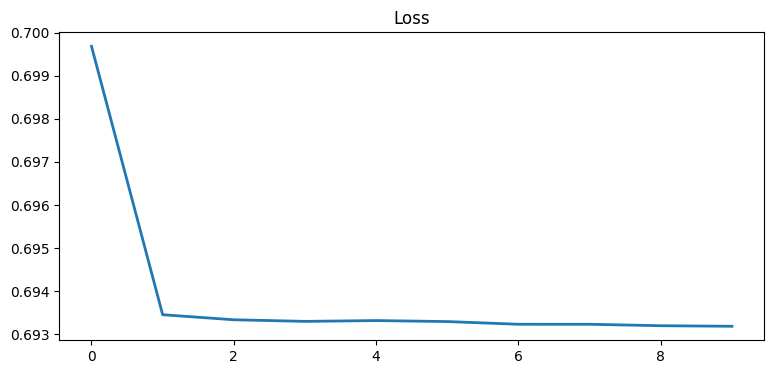

In [25]:
history=history_byte_lstm
# Plot loss LSTM BYTECODE
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy') be 
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
history=history_source_lstm
# Plot loss LSTM SOURCE CODE
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

# Section 5: BERT

In [ ]:
# Build Neural Network with BERT
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') #input

preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') #BERT tokenizer
tokenized = preprocessor(text_input)

encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') #BERT embedding and encoding
embedded = encoder(tokenized)

net = embedded['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(32, activation='relu',)(net)
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

model_BERT = tf.keras.Model(text_input, net)
model_BERT.summary()

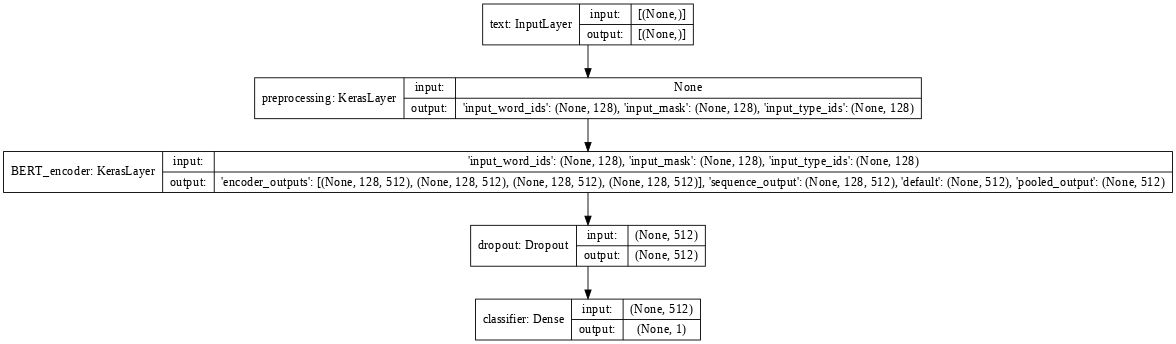

In [ ]:
# Plot it
tf.keras.utils.plot_model(model_BERT, show_shapes=True, show_layer_names=True, dpi=64)

In [ ]:
# Custom compilation
epochs = 5
steps_per_epoch = 500
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model_BERT.compile(optimizer=optimizer,
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=tf.metrics.BinaryAccuracy())

In [ ]:
# Training
history_byte_bert = model_BERT.fit(x=xtrain_byte, y=ytrain, epochs=10,validation_data=(xtest_byte, ytest))

In [ ]:
# Training
history_source_bert = model_BERT.fit(x=xtrain_source, y=ytrain, epochs=10,validation_data=(xtest_byte, ytest))

In [ ]:
history=history_source_bert
# Plot loss SOURCE BERT
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
history=history_byte_bert
# Plot loss SOURCE BERT
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
# Evaluate on test set SOURCE
loss_source_bert, accuracy_source_bert = model_BERT.evaluate(xtest_source, ytest)

print(f'Loss: {loss_source_bert}')
print(f'Accuracy: {accuracy_source_bert}')

In [ ]:
# Evaluate on test set SOURCE
loss_byte_bert, accuracy_byte_bert = model_BERT.evaluate(xtest_byte, ytest)

print(f'Loss: {loss_byte_bert}')
print(f'Accuracy: {accuracy_byte_bert}')